In [1]:
#!pip install pyod

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
#import random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as k
from pyod.utils.data import generate_data
from pyod.models.auto_encoder import AutoEncoder
import json
#from keras.utils import plot_model

In [3]:
df = pd.read_csv("Normalized_df.csv")

In [4]:
# Encoder_Model = AutoEncoder(hidden_neurons =[128, 64, 32, 64, 128], epochs = 10,l2_regularizer = 0.01, dropout_rate = 0.05, contamination = 0.1, validation_size = 0.)
# Encoder_Model.fit(df.loc[(df['Year'] >= 2016) & (df['Year'] <= 2018)][:10000])

In [5]:
# Specify search space
epochsList = [50]
hidden_neuronsList = [[128, 64, 32, 64, 128],[64, 32, 16, 32, 64]]
dropout_rateList = [0.05]
l2_regularizerList = [0.01, 0.001]
contaminationList = [0.1]

In [6]:
# Specify search space
epochsList = [50]
hidden_neuronsList = [[128, 64, 32, 64, 128]]
dropout_rateList = [0.05]
l2_regularizerList = [0.001]
contaminationList = [0.1]

In [7]:
# Construct dictionary associated with search space
SearchSpaceDict = {}
cnt = 1
for epochs in epochsList:
    for hidden_neurons in hidden_neuronsList:
        for dropout_rate in dropout_rateList:
            for l2_regularizer in l2_regularizerList:
                for contamination in contaminationList:
                    SearchSpaceDict["Model_{}".format(str(cnt))] = {"epochs":epochs, 
                                                                    "hidden_neurons":hidden_neurons, 
                                                                    "dropout_rate":dropout_rate, 
                                                                    "l2_regularizer":l2_regularizer, 
                                                                    "contamination":contamination
                                                                    }
                    cnt = cnt + 1
print(SearchSpaceDict)
with open("SearchSpaceDict.json", "w") as outfile: 
    json.dump(SearchSpaceDict, outfile)

{'Model_1': {'epochs': 50, 'hidden_neurons': [128, 64, 32, 64, 128], 'dropout_rate': 0.05, 'l2_regularizer': 0.001, 'contamination': 0.1}}


In [8]:
# ###################################################
# # Run all models associated with the search space #
# ###################################################
# ModelResults = {}
# # Iterate through search space dictionary
# for CurModelKey in SearchSpaceDict.keys():
#     #try:
#     ModelResults[CurModelKey] = {'input_parameters':SearchSpaceDict[CurModelKey], 
#                                  'model':AutoEncoder(epochs = SearchSpaceDict[CurModelKey]["epochs"], 
#                                                      hidden_neurons = SearchSpaceDict[CurModelKey]["hidden_neurons"], 
#                                                      dropout_rate = SearchSpaceDict[CurModelKey]["dropout_rate"], 
#                                                      l2_regularizer = SearchSpaceDict[CurModelKey]["l2_regularizer"], 
#                                                      contamination = SearchSpaceDict[CurModelKey]["contamination"],
#                                                      validation_size = 0., batch_size = 32)
#                                 }
#     ModelResults[CurModelKey]['model'].fit(df.loc[(df['Year'] >= 2016) & (df['Year'] <= 2018)])
#     ModelResults[CurModelKey]['output'] = ModelResults[CurModelKey]['model'].history_["loss"][-1]
#     ModelResults[CurModelKey]['model'].model_.save(CurModelKey)
#     #except:
#     #    print("no")
#     #    pass

In [9]:
# Train the best model
# m = np.inf
# for key in ModelResults.keys():
#     if ModelResults[key]['output'] < m:
#         k = key
#         m = ModelResults[key]['output']
# print("BEST MODEL: " + k)
k = 'Model_1'
        
Encoder_Model = AutoEncoder(epochs = SearchSpaceDict[k]["epochs"],
                            hidden_neurons = SearchSpaceDict[k]["hidden_neurons"],
                            dropout_rate = SearchSpaceDict[k]["dropout_rate"],
                            l2_regularizer = SearchSpaceDict[k]["l2_regularizer"], 
                            contamination = SearchSpaceDict[k]["contamination"],
                            validation_size = 0.,
                            batch_size = 32
                           )        
        
Encoder_Model.fit(df.loc[(df['Year'] >= 2016) & (df['Year'] <= 2018)])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 673)               453602    
_________________________________________________________________
dropout (Dropout)            (None, 673)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 673)               453602    
_________________________________________________________________
dropout_1 (Dropout)          (None, 673)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               86272     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.05, epochs=50,
      hidden_activation='relu', hidden_neurons=[128, 64, 32, 64, 128],
      l2_regularizer=0.001,
      loss=<function mean_squared_error at 0x0000023F83D02A60>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.0, verbose=1)

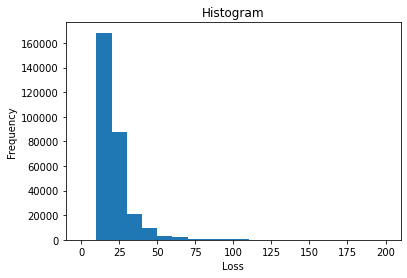

In [10]:
train_scores = Encoder_Model.decision_scores_.copy()
train_bins = []
for i in range(0, 210, 10):
    train_bins.append(i)
for idx, score in enumerate(train_scores):
    if score > 200:
        train_scores[idx] = 200
plt.hist(train_scores, bins=train_bins)  
plt.title("Histogram")
plt.ylabel("Frequency")
plt.xlabel("Loss")
plt.savefig("Train.pdf")
plt.show()
plt.close()
del train_bins
del train_scores

In [11]:
# count = 0
# print(len(y_train_scores))
# for i in y_train_scores:
#     if i > 200:
#         count += 1
# print(count)

In [12]:
# Predict the anomaly scores
y_test_scores = Encoder_Model.decision_function(df.loc[df['Year'] > 2018])  # outlier scores
y_test_scores = pd.Series(y_test_scores) 

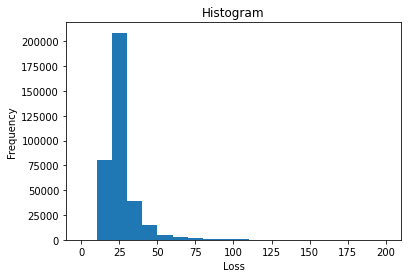

In [13]:
test_bins = []
test_scores = y_test_scores.copy()
for i in range(0, 210, 10):
    test_bins.append(i)
for idx, score in enumerate(test_scores):
    if score > 200:
        test_scores[idx] = 200
plt.hist(test_scores, bins=test_bins)  
plt.title("Histogram")
plt.ylabel("Frequency")
plt.xlabel("Loss")
plt.savefig("Test.pdf")
plt.show()
plt.close()
del test_bins
del test_scores

In [14]:
#Saving reconstruction errors for training and testing set
y_train_scores = Encoder_Model.decision_scores_
with open("y_train_scores.json", "w") as outfile: 
    json.dump(y_train_scores.tolist(), outfile)
with open("y_test_scores.json", "w") as outfile: 
    json.dump(y_test_scores.tolist(), outfile)

In [15]:
#Opening the file containing reconstruction errors
with open("y_test_scores.json") as f:
    rec_errors = json.load(f)

In [16]:
# Saving the dataset with reconstruction errors
new_df = df.loc[df['Year'] > 2018].reset_index().drop('index', axis = 1)
new_df['reconstruction_error'] = rec_errors
new_df.sort_values('reconstruction_error', ascending = True, inplace = True, ignore_index = True)
new_df['Index'] = [x for x in range(1, len(new_df) + 1)]
new_df['percentile_rec_errors'] = new_df['Index']/(len(new_df)+1)
del new_df['Index']
del new_df['reconstruction_error']
display(new_df)
new_df.to_csv("Testing_with_errors.csv", index = False)
del new_df
del rec_errors

trans_tracking_nbr  Year  min_age_oldest_driver  \
0                 90909845  2019               0.655242   
1                 91559625  2019              -0.376913   
2                 90994616  2019              -0.073338   
3                 99914543  2019              -0.619773   
4                 91296468  2019               0.776672   
...                    ...   ...                    ...   
355551           137540519  2019              -1.287637   
355552           154527706  2020               0.048092   
355553           169886732  2020               0.776672   
355554           112213697  2019               1.383821   
355555           101657511  2019               0.290952   

        min_age_youngest_driver   min_cbr  min_cbr_insufficientcredit_ind  \
0                      0.073559 -1.003318                       -0.176531   
1                     -0.126347 -0.962966                       -0.176531   
2                     -0.067551 -0.120074                       -0.176531   
3                     -0.161625 -0.120074                       -0.176531   
4                      0.050041 -0.568421                       -0.176531   
...                         ...       ...                             ...   
355551                -0.279217 -0.936066                       -0.176531   
355552                -0.067551 -0.104105                       -0.176531   
355553                -0.232180 -0.104105                       -0.176531   
355554                -0.338013  0.026907                       -0.176531   
355555                -0.220421  1.224967                       -0.176531   

        min_cbr_nohit_ind  min_cbrscore  min_chargeable13  min_chargeable45  \
0               -0.113304      0.935884          0.680332         -0.303277   
1               -0.113304      0.820705         -0.504462         -0.303277   
2               -0.113304      0.504786         -0.504462         -0.303277   
3               -0.113304      0.462005          0.680332         -0.303277   
4               -0.113304      0.613383         -0.504462         -0.303277   
...                   ...           ...               ...               ...   
355551          -0.113304      0.761470          1.865127         -0.303277   
355552          -0.113304     -1.693483          1.865127         -0.303277   
355553          -0.113304     -1.693483         -0.504462         -0.303277   
355554          -0.113304     -1.693483          1.865127         -0.303277   
355555          -0.113304      0.244811         -0.504462         -0.303277   

        ...  operatorstatus_inactiveoperator  operatorstatus_nonoperator  \
0       ...                        -0.049345                   -0.149307   
1       ...                        -0.049345                   -0.149307   
2       ...                        -0.049345                   -0.149307   
3       ...                        -0.049345                   -0.149307   
4       ...                        -0.049345                   -0.149307   
...     ...                              ...                         ...   
355551  ...                        -0.049345                   -0.149307   
355552  ...                        -0.049345                   -0.149307   
355553  ...                        -0.049345                   -0.149307   
355554  ...                        -0.049345                   -0.149307   
355555  ...                        -0.049345                   -0.149307   

        operatorstatus_nan  relationship_civunion  \
0                -0.013952              -0.016481   
1                -0.013952              -0.016481   
2                -0.013952              -0.016481   
3                -0.013952              -0.016481   
4                -0.013952              -0.016481   
...                    ...                    ...   
355551           -0.013952              -0.016481   
355552           -0.013952              -0.016481   
355553           -0.013952         